In [85]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''LSTMで時系列予測を行う'''

'LSTMで時系列予測を行う'

In [86]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [87]:
import gc
from matplotlib import pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import shutil
from sklearn.metrics import mean_squared_error

In [88]:
# 乱数固定
SEED = 20241001
keras.utils.set_random_seed(SEED)
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import numpy as np
np.random.seed(SEED)
import random
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

In [89]:
# 定数
BATCH_SIZE = 12	# ミニバッチのサイズ
EPOCHS = 450	# 学習回数(1〜)
N_TEST = 12	# 最後のこの月数分を予測する
TIMESTEPS_IN = 12	# 入力時系列長
TIMESTEPS_OUT = 1	# 出力時系列長

VALIDATION_SPLIT = 0.2 # 学習データ末尾からこの比率だけ精度確認用に用いる

N_TRIALS = 1	# ハイパーパラメータの探索トライアル数
N_LOOPS = 5	# ハイパーパラメータの探索トライアルループ数(総トライアル数=N_TRIALS*N_LOOPS)

SAVE_NAME = 'study_rnn'

In [90]:
# データを生成する関数
def make_data(X):
    # 念のためnp.arrayに変換
    x = np.asarray(X) if X.ndim	> 1 else np.asarray(X).reshape(-1, 1)

    # x+yの配列に変換
    x = np.asarray([x[i:i+TIMESTEPS_IN+TIMESTEPS_OUT] for i in range(len(x)-TIMESTEPS_IN-TIMESTEPS_OUT+1)])

    # BATCH_SIZEの倍数になるよう先頭を切り捨て
    x = np.asarray(x[len(x)%BATCH_SIZE:])

    # xとyに分離
    x_data = x[:, :TIMESTEPS_IN].reshape(-1, TIMESTEPS_IN, x.shape[-1])
    y_data = x[:, -TIMESTEPS_OUT:].reshape(-1, TIMESTEPS_OUT, x.shape[-1])

    # n_train_trainを算出
    n_train = len(x)-N_TEST
    n_train_train = int(n_train*(1-VALIDATION_SPLIT)//BATCH_SIZE*BATCH_SIZE)

    # train, val, testに分割
    x_train = x_data[:n_train_train]
    y_train = y_data[:n_train_train]
    x_val = x_data[n_train_train:-N_TEST]
    y_val = y_data[n_train_train:-N_TEST]
    x_test = x_data[len(x_data)-N_TEST:]
    y_test = y_data[len(y_data)-N_TEST:]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [91]:
# モデルを構築する関数
def make_model(layers, stateful, units, dropout):
    inputs = keras.layers.Input(batch_shape=(BATCH_SIZE, TIMESTEPS_IN, 1))
    x = inputs
    for i in range(layers):
        x = keras.layers.LSTM(units=units, stateful=stateful, return_sequences=(i < layers-1))(x)
        
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(TIMESTEPS_OUT)(x)
    outputs = keras.layers.Reshape(target_shape=(TIMESTEPS_OUT, 1))(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [92]:
# モデル内の全レイヤのreset_stetesを呼び出す関数
def reset_states(model):
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

In [93]:
# エポック終了時に実行(pruneなし)
def on_epoch_end(epoch, logs={}):
    reset_states(model)

In [94]:
# 最適化の目的関数
def objective(trial, optimize=True):

    # エポック終了時に実行(pruneあり)
    def on_epoch_end_prune(epoch, logs={}):
        trial.report(logs.get('loss'), epoch)
        if trial.should_prune():
            print(f'pruned: epoch={epoch}, loss={logs.get("loss")}, val_loss={logs.get("val_loss")}')
            raise optuna.TrialPruned()

        reset_states(model)

    # ハイパーパラメータ
    layers = trial.suggest_int('layers', 1, 6) # LSTMレイヤの数(1〜)
    stateful = True # LSTMをstatefulにするかどうか(False/True)
    units = trial.suggest_int('units', 1, 128) # LSTM層の出力ユニット数(1〜)
    dropout = trial.suggest_float('dropout', 0, 0.5) # LSTM層からの出力のドロップアウト率(0.0〜1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.000001, 0.1)	# 学習率(0<)

    # 学習用モデル生成
    model = make_model(
        layers=layers,
        stateful=stateful,
        units=units,
        dropout=dropout,
    )
    
    # 学習ループ構築
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=0.001), loss=keras.losses.LogCosh(), metrics=['mse'])

    # コールバック(pruneあり)
    callback = keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end_prune)

    # 学習(validation_split=VALIDATION_SPLIT)
    try:
        model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val), shuffle=False, verbose=0, callbacks=[callback])
    except optuna.TrialPruned as e:
        print(f'TrialPruned: {e}')
        raise optuna.TrialPruned()
    except KeyboardInterrupt:
        print('keyboard interrupted')
        val_loss, val_mse = float('nan'), float('nan')
    except Exception as e:
        print(f'Error: {e}')
        val_loss, val_mse = float('nan'), float('nan')
    else:
        # 精度を計算
        # epoch終了時にstateはリセットされているのでここでのリセットは不要
        model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0) # stateを進める
        val_loss, val_mse = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE, verbose=0)
    finally:
        # 掃除
        del model
        keras.backend.clear_session()
        gc.collect
    
    print(f'{val_loss=}, {val_mse=}')

    # 結果を返す(MSE最小化を目指す)
    return val_mse

In [95]:
# データ読み込み
df = pd.read_csv('data/international-airline-passengers.csv', engine='python', skipfooter=3)
df_p = df['passengers']

In [96]:
# 標準化
std = df_p.std()
mean = df_p.mean()
df_s = (df_p - mean) / std

In [97]:
# データ整形
(x_train, y_train), (x_val, y_val), (x_test, y_test) = make_data(df_s)
print(f'{x_train.shape=}, {y_train.shape=}, {x_val.shape=}, {y_val.shape=}, {x_test.shape=}, {y_test.shape=}')

x_train.shape=(84, 12, 1), y_train.shape=(84, 1, 1), x_val.shape=(24, 12, 1), y_val.shape=(24, 1, 1), x_test.shape=(12, 12, 1), y_test.shape=(12, 1, 1)


In [98]:
# 開始時刻記録
import time
start_time = time.time()

In [99]:
# 既に最適化済みのパラメータセットがあればここに設定する
best_params={}

In [100]:
# ハイパーパラメータ最適化
if not best_params:
    sampler = optuna.samplers.TPESampler(seed=SEED)
    pruner = optuna.pruners.HyperbandPruner(min_resource=1, max_resource=EPOCHS, reduction_factor=3)
    study = optuna.create_study(sampler=sampler, pruner=pruner)

    for i in range(N_LOOPS):
        study.optimize(objective, n_trials=N_TRIALS)

        sum_trials = N_TRIALS*(i+1)

        # ハイパーパラメータ最適化の結果
        print(f'best_params[{sum_trials:04d}]={study.best_params} # best_value={study.best_value}')

        # 結果保存
        with open(f'{SAVE_NAME}{sum_trials:04d}.pkl', 'wb') as f:
            pickle.dump(study, f)

        # 古いシンボリックリンクがあれば削除
        if os.path.islink('study.pkl'):
            os.remove('study.pkl')

        try:
            # 最新の結果をstudy.pklとしてシンボリックリンクを作っておく
            os.symlink(f'{SAVE_NAME}{sum_trials:04d}.pkl', 'study.pkl')
        except Exception as e:
            # シンボリックリンクがだめならコピーする
            shutil.copy2(f'{SAVE_NAME}{sum_trials:04d}.pkl', 'study.pkl')

    best_params = study.best_params

[I 2025-06-03 18:52:06,122] A new study created in memory with name: no-name-f3a71a6d-c299-47b4-8c88-c3e4d9e30c63
[I 2025-06-03 18:52:59,875] Trial 0 finished with value: 0.04363824054598808 and parameters: {'layers': 1, 'units': 40, 'dropout': 0.05361584483320092, 'learning_rate': 0.01841361563364898}. Best is trial 0 with value: 0.04363824054598808.


val_loss=0.021276624873280525, val_mse=0.04363824054598808
best_params[0001]={'layers': 1, 'units': 40, 'dropout': 0.05361584483320092, 'learning_rate': 0.01841361563364898} # best_value=0.04363824054598808


[I 2025-06-03 18:53:58,334] Trial 1 finished with value: 0.18168681859970093 and parameters: {'layers': 2, 'units': 37, 'dropout': 0.23802507836915165, 'learning_rate': 0.09959919905218795}. Best is trial 0 with value: 0.04363824054598808.


val_loss=0.08494734764099121, val_mse=0.18168681859970093
best_params[0002]={'layers': 1, 'units': 40, 'dropout': 0.05361584483320092, 'learning_rate': 0.01841361563364898} # best_value=0.04363824054598808


[I 2025-06-03 18:55:32,305] Trial 2 finished with value: 2.316866874694824 and parameters: {'layers': 5, 'units': 73, 'dropout': 0.4727125650511506, 'learning_rate': 0.08662394737356426}. Best is trial 0 with value: 0.04363824054598808.


val_loss=0.7964575290679932, val_mse=2.316866874694824
best_params[0003]={'layers': 1, 'units': 40, 'dropout': 0.05361584483320092, 'learning_rate': 0.01841361563364898} # best_value=0.04363824054598808


[I 2025-06-03 18:55:40,461] Trial 3 pruned. 


pruned: epoch=1, loss=0.45305338501930237, val_loss=0.1715436577796936
TrialPruned: 
best_params[0004]={'layers': 1, 'units': 40, 'dropout': 0.05361584483320092, 'learning_rate': 0.01841361563364898} # best_value=0.04363824054598808


[I 2025-06-03 18:56:41,881] Trial 4 finished with value: 0.10641346126794815 and parameters: {'layers': 2, 'units': 38, 'dropout': 0.4864855660495925, 'learning_rate': 0.026575326094975683}. Best is trial 0 with value: 0.04363824054598808.


val_loss=0.051418859511613846, val_mse=0.10641346126794815
best_params[0005]={'layers': 1, 'units': 40, 'dropout': 0.05361584483320092, 'learning_rate': 0.01841361563364898} # best_value=0.04363824054598808


In [101]:
# 所要時間表示
elapsed_time = time.time() - start_time
print(f'elapsed time: {elapsed_time}[sec]')

elapsed time: 275.79645586013794[sec]


In [102]:
# 最適化済みのパラメータセットを表示
print(f'{best_params=}')

best_params={'layers': 1, 'units': 40, 'dropout': 0.05361584483320092, 'learning_rate': 0.01841361563364898}


In [103]:
# ハイパーパラメータ設定
layers = best_params['layers']
stateful = True
units = best_params['units']
dropout = best_params['dropout']
learning_rate = best_params['learning_rate']

In [104]:
# 最適化したハイパーパラメータでモデルを構築
model = make_model(layers, stateful, units, dropout)

In [105]:
# 学習ループ構築
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=0.001), loss=keras.losses.LogCosh(), metrics=['mse'])

In [106]:
# モデルの表示
keras.utils.plot_model(model, to_file='model.png')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (12, 12, 1)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (12, 40)               │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (12, 40)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (12, 1)                │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (12, 1, 1)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,761 (26.41 KB)

 Trainable params: 6,761 (26.41 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
# コールバック(pruneなし)
callback = keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

# 全データで学習(validation_split=0)
model.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0, shuffle=False, verbose=0, callbacks=[callback])

In [108]:
# 予測
# epoch終了時にstateはリセットされているのでここでのリセットは不要
p_train = model.predict(np.concatenate((x_train, x_val)), batch_size=BATCH_SIZE)
p_test = model.predict(x_test, batch_size=BATCH_SIZE)
print(f'{p_train.shape=}, {p_test.shape=}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
p_train.shape=(108, 1, 1), p_test.shape=(12, 1, 1)


In [109]:
# 精度を計算
loss = mean_squared_error(np.concatenate((y_train, y_val)).flatten(), p_train.flatten())
test_loss = mean_squared_error(y_test.flatten(), p_test.flatten())
print(f'{loss=}, {test_loss=}')

loss=0.01224020103558602, test_loss=0.03389306003079121


In [110]:
# 横軸
time = range(len(df))

In [111]:
# 1次元にし、標準化を元に戻す
p_train = p_train[:,-1,:].flatten() * std + mean
p_test = p_test[:,-1,:].flatten() * std + mean

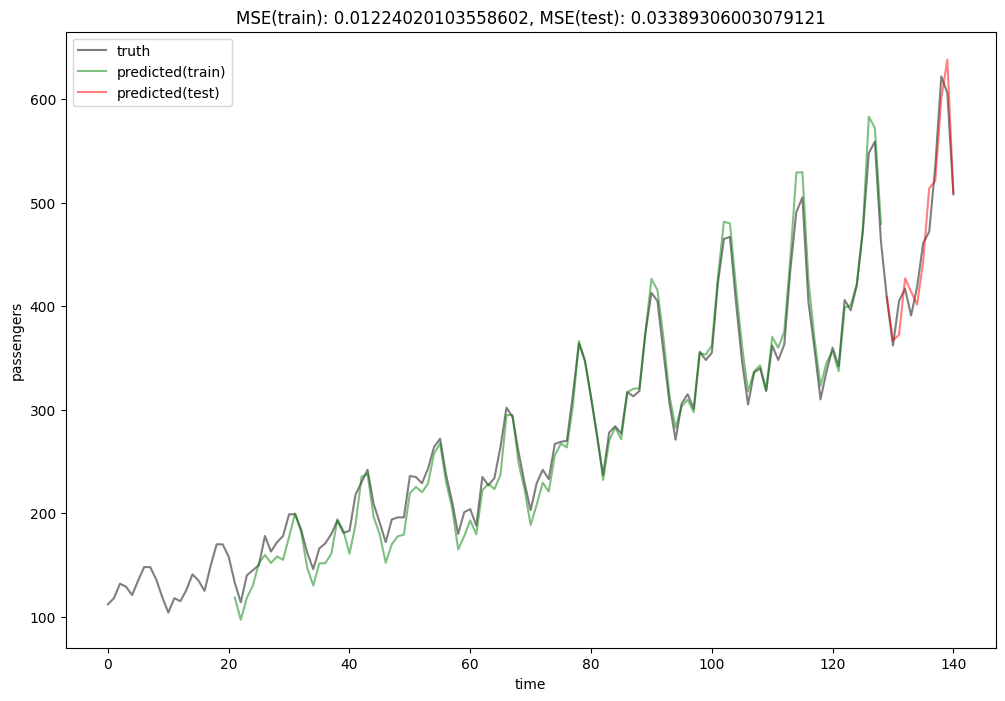

In [112]:
# グラフの描画およびファイル保存
fig = plt.figure(figsize=(12, 8))
plt.subplot(111)
plt.plot(time, df_p, color='k', label='truth', alpha=0.5)
plt.plot(time[-len(p_train)-len(p_test):-len(p_test)], p_train, color='g', label='predicted(train)', alpha=0.5)
plt.plot(time[-len(p_test):], p_test, color='r', label='predicted(test)', alpha=0.5)
plt.xlabel('time')
plt.ylabel('passengers')
plt.title(f'MSE(train): {loss}, MSE(test): {test_loss}')
#plt.legend(bbox_to_anchor=(0, 0), loc='upper left', borderaxespad=0)
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.savefig('plot.png') # ファイル出力
plt.show() # コマンドラインからの実行の場合に描画する(jupyterの場合は既に描画済みなので何も出ません)